## Analyzing and Visualizing Meshes - Tutorial

In many instances you may have a subset of cells that you are interested in and would like to conduct further analysis on those cells in particular. One way to do this is to work with the 3D segmentation in mesh form. This is not only useful for making beautiful visualization but allows you to extract relevant shape and morphology features that would not be available with a skeleton. This notebook will show you how to do the following:
   - How to load a mesh with a specific id (e.g. your cell of interest)
   - How to extract the relevant synapses from the soma subgraph
   - How to make a 2D visualization of your cell with it's synapses
   - How to use graph algorithms to find the distance between points on your cell
   - How to visualize your cell and synapses in 3D

#### Prerequisites:
To run this notebook please make sure to have [Meshparty](https://github.com/sdorkenw/MeshParty/tree/master/meshparty) installed

Please download the following files: 
   - Two example [meshes](https://figshare.com/projects/Open_For_Science_-_MICrONS_Explorer_Tutorial/99908)
   - Proofread [soma subgraph synapses](https://microns-explorer.org/phase1)

In [1]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

### How to load a mesh in with a specific ID
There are two ways to load a mesh with our framework. The first is reading off disk which we recommend particularly for any cell with a soma in the volume since those have been provided for you. The second is downloading a mesh directly from the cloudvolume, this can be useful for orphan axons or dendrite you may be interested in.

You can pick your favorite segid from neuroglancer, by copying the IDs from the right hand panel.

A word of caution that sometimes a neuron contacts itself, such as when it's axon touches it's own dendrite.  
Also there are gaps in the meshes when missing data caused a break in the segmentation that was fixed by proofreading.

In such cases the mesh topology does not reflect the real topology of cell membranes.
The meshes in the tar file on the website are better in this respect but are only for the cells with cell bodies in the volume.

If you unpack the tar file and set the disk_cache_directory to that directory, the MeshMeta will read those meshes instead of downloading new files.

In [2]:
# setup the mesh meta to handle downloads and caching
mesh_dir = '../data/'
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path=mesh_dir, 
                         cache_size=20)



In [3]:
# Read mesh off disk
seg_id = 648518346349539856
mesh_file = os.path.join(mesh_dir, str(seg_id)+'.h5')
mesh = mm.mesh(mesh_file)

You can check the mesh properties of your object by calling its vertices and faces

In [4]:
mesh.n_vertices, mesh.n_faces

(2275414, 4550808)

Now let's say you want to create another mesh object for one of the presynaptic partners. You can do so by directly downloading it with cloudvolume. Make sure that your MeshMeta instance has the proper segmentation source (found in a first cell of this notebook), and a directory to download the mesh to.

In [5]:
# Download the mesh via cloudvolume and convert it to a Mesh object (an extension of trimesh)
# https://github.com/mikedh/trimesh
# see MeshParty docs https://meshparty.readthedocs.io/en/latest/?badge=latest
second_seg_id = 648518346349538192
second_mesh = mm.mesh(seg_id = second_seg_id, remove_duplicate_vertices=True)



Decoding Mesh Buffer: 100%|██████████| 260/260 [00:00<00:00, 6565.00it/s]


In [6]:
second_mesh.n_vertices

1623745

### How to extract relavent synapses from the soma subgraph

The soma subgraph file contains further proofread synapses between all excitatory cells with somas in the dataset and includes spine head volume measurements per synapse. Let's take a look at an example analysis

In [7]:
# read in the synapses file
soma_subgraph_df = pd.read_csv('../data/soma_subgraph_synapses_spines_v185.csv')

In [8]:
soma_subgraph_df.head()

,id,pre_root_id,post_root_id,cleft_vx,spine_vol_um3,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,1484,648518346349539437,648518346349531254,798,0.133004,365476,231192,63280,91332,57836,1584,91369,57798,1582,91332,57748,1584
1,3056393,648518346349537978,648518346349531254,209,0.087794,312120,209816,9960,78050,52470,248,78030,52454,249,77980,52444,249
2,310116,648518346349538410,648518346349531254,869,0.234537,313596,185764,23920,78314,46428,598,78399,46441,598,78404,46410,598
3,1533059,648518346349538410,648518346349531254,231,0.081921,289560,174904,33920,72340,43756,849,72390,43726,848,72354,43704,849
4,2505779,648518346349538410,648518346349531254,669,0.105706,296056,162304,9520,73966,40608,231,74014,40576,238,73918,40562,232


You can filter the synapses to only look at those on your cell of interest and make an array of xyz positions for each synapse

In [9]:
# filter the synapses onto this cell
cell_post_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}')

# make an array of xyz synapse positions
syn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

### How to make a simple 2D visualization of your cell and its synapses

Now let's make a simple visualization of your cell, with points marking synapses made onto the cell 

(308462.6875, 144806.703125)

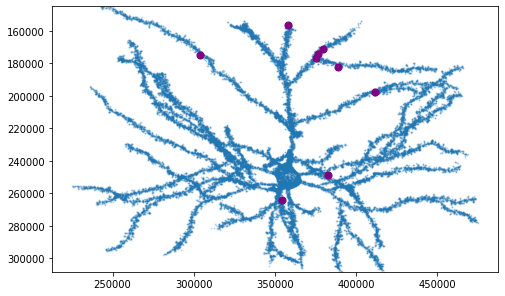

In [10]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=1, alpha=.2)
# add in the locations of synapses between cell bodies

ax.scatter(syn_xyz[:,0], syn_xyz[:,1], c='purple', s=50)
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))


In order to run graph based analyses on these synapses it is usually helpful to map each synapse to its closest vertex on your cell mesh, you can do this by making use of kdtree on the mesh vertices to speed lookup and will return the distance and closest vertex index 

In [11]:
cell_conn_graph = cell_post_subgraph.query(f'pre_root_id=={second_seg_id}')
syn_xyz=cell_conn_graph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

In [12]:
syn_xyz

array([[376776, 174200,  38120],
       [379624, 171344,  35960],
       [375532, 176616,  36800],
       [382496, 248800,  13760],
       [354656, 264332,  15120]])

In [13]:
syn_ds, syn_mesh_inds=mesh.kdtree.query(syn_xyz)

In [14]:
# all the distances are quite close < ~110 nm
# mesh vertices have ~150 nm spacing
syn_ds, syn_mesh_inds

(array([50.71707724, 48.42520005, 67.60975055, 67.05221846, 45.96755235]),
 array([1533305, 1554127, 1524041, 1573520, 1113075]))

In [15]:
# import scipy's spare graph library
from scipy import sparse

Now we can use graph algorithms to calculate the shortest paths on the mesh. This example finds all the distances from the first synapse along with a data structure that leaves pointers about how to backtrack to that index point

In [16]:
ds, path = sparse.csgraph.dijkstra(mesh.csgraph,
                             directed=False,
                             return_predecessors=True,
                             indices=syn_mesh_inds[0])

In [17]:
path

array([      8,      24,       7, ..., 2275408, 2275408, 2275407],
      dtype=int32)

In [18]:
# convert the predecessors into a path from synapse 1 to synapse 0
syn_to_syn_path = utils.get_path(syn_mesh_inds[0], syn_mesh_inds[3], path)

We can make a simple 2D visualization of these results by plotting the path between synapse 0 and synapse 1 onto our cell of interest. We will color the mesh vertices by how far away they are from the first synapse, closer vertices will show up in darker purple and blue, while farther points will be in light green or yellow. Again, all synapses will be shown as large purple points.

(308462.6875, 144806.703125)

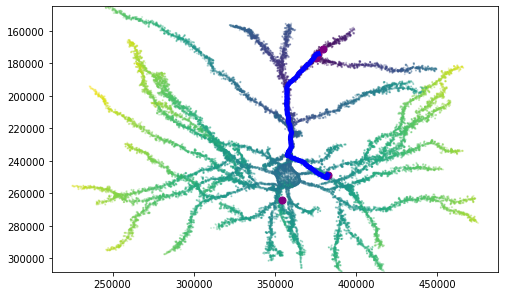

In [19]:
# let's make a simple 2d visualization of thes results
f,ax = plt.subplots(figsize=(8,8))

# now we will color the mesh vertices by how far they are from the synpase
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], c=ds[::50], s=1, alpha=.2)

# let plot the path between the synapses
ax.plot(mesh.vertices[syn_to_syn_path,0], mesh.vertices[syn_to_syn_path,1], 'b', linewidth=5)
# and plot the synapse locations again
ax.scatter(syn_xyz[:,0], syn_xyz[:,1], c='purple', s=50)
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))


These mesh files are not used in the Binder example as it would make the image too large.

### How to visualize your cell in 3D

It's more fun to visualize things in 3d though, and while neuroglancer is great, it's more difficult to control exactly what you want to visualize such as only components of mesh, or colorings, or angle.
If you're interested in more options in this area, checkout trimesh_vtk in the MeshParty documentation.

For this example we will visualize our cell in yellow with an opacity level of 0.2 to increase its transparency. The path between synapse 0 and synapse 1 will be shown in blue.

In [26]:
from itkwidgets import view

# need to convert path to a set of edges
edges = utils.paths_to_edges([syn_to_syn_path])
# create a set of vertices and edges for path
sk_verts, sk_edges = trimesh_vtk.remove_unused_verts(mesh.vertices,
                                                     edges)
# create a vtk polydata from this
sk_poly = trimesh_vtk.graph_to_vtk(sk_verts, sk_edges)


# convert cell mesh to vtkpolydata as well
poly_data = trimesh_vtk.trimesh_to_vtk(mesh.vertices, mesh.faces, None)

# step 2
# then create a viewer with this view function
# pass in polydata objects, what colors you want
# see docstring for more options
viewer=view(geometries=[poly_data, sk_poly],
            geometry_colors=['y','b'], 
            geometry_opacities=[.2, 1.0],
            ui_collapsed=True)


In [27]:
viewer

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

VTK is another open source package for 3D object visualizations that offers more control over your output image or movie. You can interact with this package using trimesh_vtk to create mesh, skeleton, and synapse point cloud actors, and create a camera object to direct your view. Below is an example similar to the one above but we will add synapse points and our presynaptic cell. 

For more information checkout [Meshparty](https://github.com/sdorkenw/MeshParty) and [VTK](https://vtk.org/)

In [40]:
import vtk

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.7, 0.7, 0.7))
pre_mesh_actor = trimesh_vtk.mesh_actor(second_mesh, opacity=.3, color=(0.2, 0.4, 0.7))
syn_actor = trimesh_vtk.point_cloud_actor(syn_xyz, size=1000, color=(0.9, 0.2, 0.2))


#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor,syn_actor,pre_mesh_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


(vtkRenderingOpenGL2Python.vtkOpenGLRenderer)0x7fd4fb16cc48